# Predict the Next Pitch

#### Goals
The first goal of this project is to build and train a machine learning model that can predict a pitcher's next pitch.  Ideally, this would involve building invididual models for each pitcher (since each pitcher is like a snowflake with their own arsenal of pitches and specific pitches that they are more comfortable with throwing in certain situations).  

The second goal of this project is to make our predictions available through a simple (and fast) API-like call.  The API should take in raw game data (such as that provided for the training) and return probabilities for each of the pitcher's different pitches.  To provide some transparancy, we will also return the accuracy of the model on test data so the user can judge how trustworthy the prediction is. 

#### Data
We will use 2011 pitch data from MLB which contains information about every pitch thrown during the year (including the game situation such as the current ball/strike count, score of the game, runners on base as well as more advanced information such as previous pitch locations, speeds and movement).  

### Import Python Modules

In [1]:
from IPython.display import Image
import re
import ast
import numpy as np
import pandas as pd
import json
import pickle
from collections import Counter
import datetime as dt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Feature Selection and Engineering

Below, we have constructed a function to select features from the training dataset and to perfom some engineering on those features.  

Our feature selection & engineering (and the subsequent model selection & training that occurs later) had to be simple enough to allow us to clean data and train a model within the suggested 3-5 hour time frame assigned for this exercise.  Therefore, in feature engineering, we decided to limit ourselves to information about the previous pitch only.  In a real world scenario, where we have much more data and more time as well as computing resouces, we would utilize the full sequence of pitches. 

Features Selected:

- Game ID and Pitcher ID: the pitcher ID is included so we can select subsets of the data and build pitcher-specific models.  We include the game ID for "groupby" operations.
- Pitch Type: this will be our "outcome" that we are trying to predict.  But, we will also use it to tabulate the type of pitch that was last thrown.
- Pitch Counts: the pitcher's total pitch count in the game, as well as the pitch count of the particular at-bat.
- Game Situation: (1) the inning (and whether it is top or bottom of that inning), (2) balls, strikes & fouls for a particular at-bat, (3) runners on base, (4) visitor and home team runs.
- Pitcher-Batter Matchup: (1) handedness of pitcher, (2) handedness of hitter, (3) height of hitter.
- Pitch Details: (1) ball, strike or in-play, (2) speed of pitch, (3) break length & angle and (4) zone of the pitch (location inside or outside of the strike zone)
- Date of Game: We use the month from the date field to include some seasonality. The reasoning behind this decision is that, as the year progresses, pitchers' arms go through stages where maybe they feel stronger (and are more apt to rely on fastball) or are suffering from "dead arm" (and are more apt to rely on offspeed stuff). Also, weather conditions can affect "feel pitches" such as curveballs, splits and/or change-ups.  Since we don't have access to the specific weather conditions of the game, seasonality is the best we can do.

Feature Cleaning & Engineering:

- Drop any rows that are missing values in the "pitch_type" column (i.e., the column we are trying to predict)
- Extract the month from the game date field (for seasonality reasons)
- Convert the "on base" fields ("on_1b", "on_2b", "on_3b") to booleans (they are originally populated with player IDs)
- Construct a boolean feature called "stand_pitch_same_side" that is true if pitcher is throwing from the same side as the hitter is hitting from (and false otherwise)
- Score differential: difference between the home and visitor runs.  We do this in a consistent way such that, if the pitcher's team is winning, the score differential is positive and, if the pitcher's team is losing, the score differential is negative.
- Construct new features for previous pitch information.  To do this, we first make a new ID out of the combination of the game and pitcher IDs.  This ensures that we're getting information from the same game.  Then, we do groupbys on this new ID and use pandas' "shift" function to grab the previous pitch's speed, type, zone, outcome, and break length/angle.
- Then, we perform some pitch type cleanup: we condense all of the different types of fastballs (e.g., four-seam, two-seam, sinker, cut fastball, split-finger fastball, etc.) into one type which we call "FB".  We also drop any rows that have pitchouts or unknown types of pitches ('PO', 'FO', 'UN', 'XX', 'IN'). 
- We map the pitch outcome ('B' for ball, 'S' for strike, 'X' for in-play) to integers for model-building purposes.

In [2]:
def prep_train_data(df):
    '''
    Function to select and clean features and generate some new features
    
    df: raw data on pitching 
    returns a cleaned dataframe ready for training
    '''
    
    # select the columns to keep
    cols_to_keep = ['game_pk', 'pitcher_id', 'pitch_type', 'inning', 'top', 'pcount_at_bat', 'pcount_pitcher', 
                    'balls', 'strikes', 'fouls', 'outs', 'on_1b', 'on_2b', 'on_3b', 
                    'b_height', 'away_team_runs', 'home_team_runs', 
                    'p_throws', 'stand', 'type', 'vy0', 'break_length', 'break_angle',  'zone', 'date']
    df = df[cols_to_keep]
    
    # drop any missing values in the outcome column ("pitch_type") 
    df = df[~pd.isna(df['pitch_type'])]

    # extract the month from the date for seasonality and drop date column
    df['month'] = df['date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d').month)
    df.drop('date', axis=1, inplace=True)
        
    # convert on_1b/on_2b/on_3b to boolean 
    df['on_1b'] = df['on_1b'].apply(lambda x: not np.isnan(x))
    df['on_2b'] = df['on_2b'].apply(lambda x: not np.isnan(x))
    df['on_3b'] = df['on_3b'].apply(lambda x: not np.isnan(x))

    # handedness: does the batter hit from the same side that the pitcher is pitching from
    df['stand_pitch_same_side'] = df['p_throws'] == df['stand'] 
    df.drop(['p_throws', 'stand'], axis=1, inplace=True)
    
    # score differential
    df['score_diff'] = -np.power(-1, df['top']) * (df['home_team_runs'] - df['away_team_runs'])
    df.drop(['home_team_runs', 'away_team_runs'], axis=1, inplace=True)
    
    # make a new id based on game id + pitcher id that we can use for groupby's
    df['game_pitcher_id'] = df['game_pk'].astype(str) + '_' + df['pitcher_id'].astype(str)
    df.drop('game_pk', axis=1, inplace=True)

    # get previous pitch type to use as a feature
    df['prev_pitch_type'] = df.groupby('game_pitcher_id')['pitch_type'].apply(lambda x: x.shift(1))

    # get previous pitch outcome to use as a feature
    df['prev_pitch_outcome'] = df.groupby('game_pitcher_id')['type'].apply(lambda x: x.shift(1))
    df.drop('type', axis=1, inplace=True)

    # get previous pitch z position to use as a feature
    df['prev_zone'] = df.groupby('game_pitcher_id')['zone'].apply(lambda x: x.shift(1))
    df.drop('zone', axis=1, inplace=True)

    # get previous break length to use as a feature
    df['prev_break_length'] = df.groupby('game_pitcher_id')['break_length'].apply(lambda x: x.shift(1))
    df.drop('break_length', axis=1, inplace=True)

    # get previous break angle to use as a feature
    df['prev_break_angle'] = df.groupby('game_pitcher_id')['break_angle'].apply(lambda x: x.shift(1))
    df.drop('break_angle', axis=1, inplace=True)

    # get previous pitch velocity to use as a feature (and convert to mph)
    df['prev_pitch_velocity'] = df.groupby('game_pitcher_id')['vy0'].apply(lambda x: x.shift(1))
    df['prev_pitch_velocity'] = round(-df['prev_pitch_velocity'] * (3600 / 5280), 0)
    df.drop('vy0', axis=1, inplace=True)

    # fill the missing prev_pitch_type and  with an Unknown token
    df['prev_pitch_type'].fillna('UN', inplace=True)
    df['prev_pitch_outcome'].fillna('UN', inplace=True)
    
    # fill missing prev_pitch_velocity with pitcher's mean velocity
    df["prev_pitch_velocity"] = df.groupby("game_pitcher_id")["prev_pitch_velocity"].transform(lambda x: x.fillna(x.mean()))
    
    # convert height of batter to inches
    def convert_height(x):
        feet = re.findall('^[0-9]', x)[0]
        inches = re.findall('.[0-9]$', x)[0]
        return 12 * int(feet) + int(inches)
    df['batter_height'] = df['b_height'].apply(convert_height)
    df.drop('b_height', axis=1, inplace=True)
    
    # drop any rows with pitchouts or unknown pitches
    pitchout_unknown_pitches = ['PO', 'FO', 'UN', 'XX', 'IN']
    df = df[~df['pitch_type'].isin(pitchout_unknown_pitches)]
    df = df[~df['prev_pitch_type'].isin(pitchout_unknown_pitches)]
    
    # map all fastball pitches into one pitch type (FB)
    fastball_pitches = ['FA', 'FF', 'FT', 'FC', 'FS', 'SI', 'SF']
    def map_fastballs(x):
        if x in fastball_pitches:
            return 'FB'
        else:
            return x
    df['pitch_type'] = df['pitch_type'].apply(map_fastballs)
    df['prev_pitch_type'] = df['prev_pitch_type'].apply(map_fastballs)

    # map previous pitch outcomes to 0 (ball, B), 1 (strike, S), 2 (in-play, X)
    def map_pitch_outcome(x):
        if x == 'B':
            return 0
        elif x == 'S':
            return 1
        else:
            return 2
    df['prev_pitch_outcome'] = df['prev_pitch_outcome'].apply(map_pitch_outcome)
    
    # reorganize the column order
    df = df[['pitcher_id', 'pitch_type', 'inning', 'top', 'pcount_at_bat', 'pcount_pitcher', 
             'balls', 'strikes', 'fouls', 'outs', 'on_1b', 'on_2b', 'on_3b', 'month', 
             'stand_pitch_same_side', 'score_diff', 'prev_pitch_type', 
             'prev_pitch_outcome', 'prev_zone', 'prev_break_length', 'prev_break_angle', 
             'prev_pitch_velocity', 'batter_height']]
    
    return df

#### Import Raw Data and Clean It

In [3]:
# import the raw data
data = pd.read_csv("./data/pitches.csv")

train_data = prep_train_data(data)

train_data.head()

,pitcher_id,pitch_type,inning,top,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,...,month,stand_pitch_same_side,score_diff,prev_pitch_type,prev_pitch_outcome,prev_zone,prev_break_length,prev_break_angle,prev_pitch_velocity,batter_height
27,450308,FB,1,0,2,2,0,1,0,0,...,3,True,0,FB,1,8.0,2.8,-0.7,87.0,70
28,450308,FB,1,0,3,3,1,1,0,0,...,3,True,0,FB,0,12.0,1.9,6.9,90.0,70
29,450308,FB,1,0,4,4,2,1,0,0,...,3,True,0,FB,0,14.0,2.3,-12.4,89.0,70
30,450308,FB,1,0,5,5,2,2,1,0,...,3,True,0,FB,1,3.0,2.1,0.1,90.0,70
31,450308,SL,1,0,6,6,2,2,2,0,...,3,True,0,FB,1,6.0,0.7,-11.3,92.0,70


### Train Pitcher-Specific Models

Below, we build pitcher-specific models using the function "train_models".  This function takes the cleaned dataframe from above as input along with a parameter called "pitch_count_cutoff".  Because there are pitchers in this dataset that have a limited amount of pitches thrown during the season, we impose this (somewhat) arbitrarily-chosen cutoff to ensure we are only building meaningful models.

The function loops through the list of pitchers that have a total pitch count above pitch_count_cutoff and:

1. Subsets the dataframe to only include the current pitcher's data
2. Builds a count dictionary of the pitcher's types of pitches
3. Builds a map (and an inverse map) of the pitcher's pitches to integers (and those integers back to the original pitch abbreviations)
4. Splits the data into a dataframe of features (X) and a dataframe of labels (y)
5. Randomly splits X/y into train and test sets using an 80/20 percent training/testing split
6. At this point, we make our choice of algorithm to use to train the model.  For the timeframe of this project and the fact that a non-linear model should do a better job in this situation, an XGBoost classifier is an excellent choice.  These types of models train fast, tend to have greater accuracy than other non-linear models (including bagging models such as Random Forests) and allow for multi-nomial classification.  In particular, we train a multi-nomial version of an XGBoost classifier using "softprob" as the objective function (this will result in each of the possible outcomes being assigned probabilities).  We also perform a small grid search over several of the XGBoost hyperparameters using 5-fold cross-validation in order to optimize them.  Again, due to time constraints, we cannot do a full hyperparameter optimization but we've chosen to optimize two of the most influential ones ("max_depth" which controls the maximum depth of the tree and, thus, the complexity of the model and "learning_rate" which controls the size of the weights of the features).   
7. Once the model has been trained, we perform predictions on the test X and compare to the corresponding test labels y.  We also compute what the accuracy would have been had the model just naively chosen the pitcher's most used pitch.  These are both stored in lists that we'll use later to assess the overall accuracy of our pitcher-specific models.
8. Finally, we store the trained model along with some metadata (pitcher's ID, the pitch maps and the model accuracy on the test data) in a pickled file.  These files will be loaded and used to make predictions in our API.

In [5]:
def train_models(train_data, pitch_count_cutoff=1000):
    '''
    Function to train and test models for pitch prediction for individual pitchers
    
    train_data: a cleaned data frame
    pitch_count_cutoff: a minimum number of pitches thrown  
    
    returns a pickled file for each pitcher that contains the model and some metadata for that pitcher
    '''

    # build a dict with pitch_id as key and total pitch count as value
    pitcher_count_dict = dict(Counter(train_data['pitcher_id']))

    # drop pitchers that don't have enough pitches to build a reliable model
    pitcher_count_dict = {k:v for k, v in pitcher_count_dict.items() if v > pitch_count_cutoff}

    # list of pitchers
    pitcher_list = pitcher_count_dict.keys()
    print(f"Number of pitchers that make the cut: {len(pitcher_count_dict)}")

    # loop through the list of pitchers and train models
    accuracy_list = []
    naive_accuracy_list = []
    num_skipped = 0
    for i, pitcher in enumerate(pitcher_list):

        # start a timer
        start = dt.datetime.now()

        df_pitcher = train_data[train_data['pitcher_id'] == pitcher]
        df_pitcher.drop('pitcher_id', axis=1, inplace=True)

        # get a unique list of the pitcher's pitches
        pitch_types = list(set(list(df_pitcher['prev_pitch_type'].unique()) + list(df_pitcher['pitch_type'].unique())))
        pitch_type_counts = Counter(df_pitcher['prev_pitch_type'])

        # build maps for pitches to ints and ints back to pitches
        pitch_map = {pitch_types[i]: i for i in range(len(pitch_types))}
        pitch_unmap = {v: k for k, v in pitch_map.items()}

        # map pitch types to ints
        df_pitcher['pitch_type'] = df_pitcher['pitch_type'].apply(lambda x: pitch_map[x])
        df_pitcher['prev_pitch_type'] = df_pitcher['prev_pitch_type'].apply(lambda x: pitch_map[x])

        # split the dataframe into a feature set and an outcome column
        X = df_pitcher.drop('pitch_type', axis=1)
        y = df_pitcher['pitch_type']

        # split the data into train/test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4256)

        # ----------------------
        # train an XGBoost model
        # ----------------------

        # small set of hyperparameters to optimize over
        xgb_params = {"max_depth": (2, 5, 20),
                      "learning_rate": (0.01, 0.1, 0.4)}

        # perform the paramater grid search using 5-fold cross validation
        xgb_opt = GridSearchCV(XGBClassifier(objective='multi:softprob', num_class=len(pitch_type_counts)), 
                               param_grid=xgb_params, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)

        # perform fit and make predictions
        xgb_opt.fit(X_train, y_train)
        y_pred = xgb_opt.predict(X_test)
        y_prob = xgb_opt.predict_proba(X_test)

        # compute accuracy and store in a list for analyzing results later
        accuracy = round(accuracy_score(y_test, y_pred) * 100, 1)
        accuracy_list.append(accuracy)

        # get and store the naive accuracy (accuracy from just predicting the most thrown pitch)
        naive_accuracy = round(max(pitch_type_counts.values()) / sum(pitch_type_counts.values()) * 100., 1)
        naive_accuracy_list.append(naive_accuracy)

        # print some input/results for every 10th pitcher
        if i % 10 == 0:
            print()
            print(f"Pitcher ID: {pitcher}")
            print(f"Pitcher's pitch map: {pitch_map}")
            print(f"Pitcher's pitch counter: {dict(pitch_type_counts)}")
            print(f"Number of data points in training: {X_train.shape[0]}")
            print(f"Number of data points in testing: {X_test.shape[0]}")
            print(f"Best params: {xgb_opt.best_params_}")
            print(f"Total training time: {dt.datetime.now()-start}")
            print(f"Naive accuracy: {naive_accuracy}")
            print(f"XGBooost accuracy: {accuracy}")


        # ----------------------------------------------------------
        # write out the pitchers model and metadata to a pickle file
        # ----------------------------------------------------------

        # things to store in the pitcher's model file:
        #  1) the map and unmap for pitches (used for data clean-up in the prediction process)
        #  2) trained model (used to make prediction)
        #  3) accuracy on the test data (to include with pitch predictions so user can see how confident the model is)
        model_out = {
            "pitcherID": pitcher,
            "pitch_map": pitch_map,
            "pitch_unmap": pitch_unmap,
            "model": xgb_opt,
            "model_accuracy": accuracy
        }

        # pickle up the pitcher's model file
        fpath = "./data/pitcher_models/" + str(pitcher) + ".pkl"
        with open(fpath, 'wb') as fobj:
            pickle.dump(model_out, fobj)
           
    # return the accuracy lists so we can perform assessment 
    return accuracy_list, naive_accuracy_list
            
accuracy_list, naive_accuracy_list = train_models(train_data, pitch_count_cutoff=2000)

Number of pitchers that make the cut: 128

Pitcher ID: 450308
Pitcher's pitch map: {'CU': 0, 'SL': 1, 'CH': 2, 'FB': 3}
Pitcher's pitch counter: {'FB': 2131, 'SL': 677, 'CU': 374, 'CH': 521}
Number of data points in training: 2962
Number of data points in testing: 741
Best params: {'learning_rate': 0.1, 'max_depth': 2}
Total training time: 0:00:15.095365
Naive accuracy: 57.5
XGBooost accuracy: 56.7

Pitcher ID: 453311
Pitcher's pitch map: {'CU': 0, 'SL': 1, 'CH': 2, 'FB': 3}
Pitcher's pitch counter: {'FB': 1907, 'SL': 847, 'CU': 252, 'CH': 531}
Number of data points in training: 2829
Number of data points in testing: 708
Best params: {'learning_rate': 0.01, 'max_depth': 2}
Total training time: 0:00:17.729481
Naive accuracy: 53.9
XGBooost accuracy: 52.7

Pitcher ID: 123801
Pitcher's pitch map: {'CU': 0, 'KN': 1, 'FB': 2}
Pitcher's pitch counter: {'KN': 2077, 'FB': 204, 'CU': 64}
Number of data points in training: 1876
Number of data points in testing: 469
Best params: {'learning_rate': 

### Analyze the Overall Results

To assess the performance of our pitcher-specific models, we look at the distribution of the difference between the models' accuracies and the naive accuracies.  We can also plot the two accuracy distributions separately and (hopefully) note a shift towards the right for the model accuracies.  

The first set of figures below show the results of these comparisons for our multi-nomial models.  We see that, even for this limited dataset and limited time for hyperparameter optimization, we do get improvement for 50% of the pitchers (above the naive predictions).  For the majority of pitchers, we only see a fractional change and more than a few show a degraded performance compared to the naive model.  It is still encouraging to see that we do have signal on half of the pitchers and that for a handful of them we see boosts in performance up to 10%.  The plot on the right shows a (very) slight shift to the right in going from the naive model to our XGBoost model.

Percentage of pitcher models with accuracy improvement over naive prediction: 49.2%


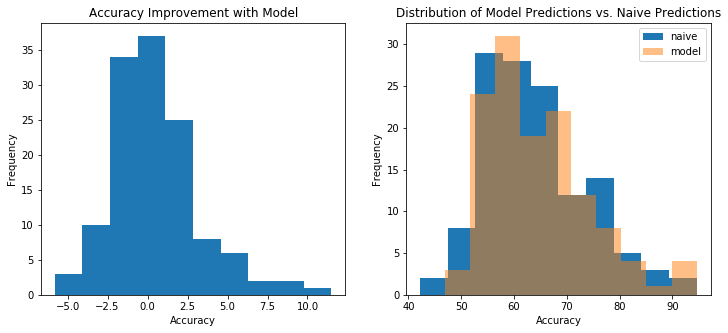

In [6]:
accuracy_diff_list = [accuracy_list[i] - naive_accuracy_list[i] for i in range(len(accuracy_list))]
pos_diff_list = [x for x in accuracy_diff_list if x > 0.]
improve_pct = round(len(pos_diff_list) / len(accuracy_diff_list) * 100., 1)
print(f"Percentage of pitcher models with accuracy improvement over naive prediction: {improve_pct}%")

fig = plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.hist(accuracy_diff_list, bins=10)
plt.title("Accuracy Improvement with Model")
plt.ylabel("Frequency")
plt.xlabel("Accuracy")

plt.subplot(1, 2, 2)
plt.hist(naive_accuracy_list, label='naive')
plt.hist(accuracy_list, alpha=0.5, label='model')
plt.title("Distribution of Model Predictions vs. Naive Predictions")
plt.ylabel("Frequency")
plt.xlabel("Accuracy")
plt.legend(loc='best')
plt.show()

For comparison's sake, we also considered a simpler problem where all pitches were mapped to either fastball or non-fastball (or "off-speed").  Below, we show the results of our binomial classification model.  We see that, in this case, nearly 60% of pitcher models show improvement over the naive model and more models have double-digit improvements (now up to 15%).  In the figure on the right, the shift of the XGBoost model accuracy is clearly seen. 

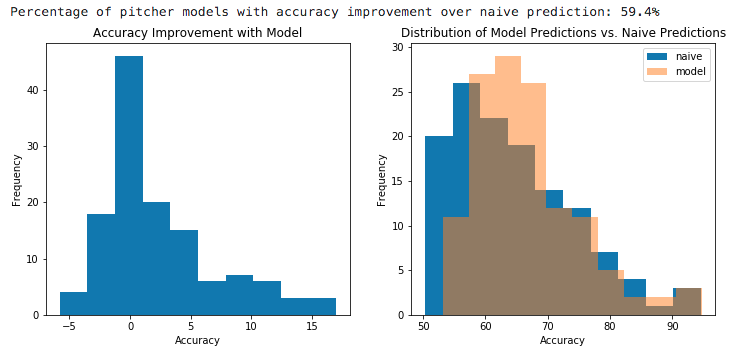

In [7]:
filename="binomial_results.png"
Image(filename=filename)

### Making Real-Time Predictions

The predictions can be made in real-time through an API call which takes in raw game data (in the form of the original training data), performs the necessary feature engineering and makes a prediction.  Below, we show the code that would be used in this API.  The function "perform_prediction" takes in information about the previous pitch in the form of a JSON string:

The function then performs the same cleanup as described above, loads the pitcher's model file and uses the stored model to make a prediction.  The predictions are then returned in the form of a dictionary which contains each of the pitchers's pitches with the corresponding predicted probability along with the model's accuracy on the test data.

In [8]:
def perform_prediction(input_data):
        
    input_df = pd.DataFrame(json.loads(input_data), index=[0])

    input_df.fillna(value=pd.np.nan, inplace=True)

    # select the columns to keep
    cols_to_keep = ['pitcher_id', 'pitch_type', 'inning', 'top', 'pcount_at_bat', 'pcount_pitcher', 
                    'balls', 'strikes', 'fouls', 'outs', 'on_1b', 'on_2b', 'on_3b', 
                    'b_height', 'away_team_runs', 'home_team_runs', 
                    'p_throws', 'stand', 'type', 'vy0', 'break_length', 'break_angle',  'zone', 'date']
    input_df = input_df[cols_to_keep]

    # extract the month from the date for seasonality and drop date column
    input_df['month'] = input_df['date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d').month)
    input_df.drop('date', axis=1, inplace=True)

    # convert on_1b/on_2b/on_3b to boolean 
    input_df['on_1b'] = input_df['on_1b'].apply(lambda x: not np.isnan(x))
    input_df['on_2b'] = input_df['on_2b'].apply(lambda x: not np.isnan(x))
    input_df['on_3b'] = input_df['on_3b'].apply(lambda x: not np.isnan(x))

    # handedness: does the batter hit from the same side that the pitcher is pitching from
    input_df['stand_pitch_same_side'] = input_df['p_throws'] == input_df['stand'] 
    input_df.drop(['p_throws', 'stand'], axis=1, inplace=True)

    # score differential
    input_df['score_diff'] = -np.power(-1, input_df['top']) * (input_df['home_team_runs'] - input_df['away_team_runs'])
    input_df.drop(['home_team_runs', 'away_team_runs'], axis=1, inplace=True)

    # rename previous pitch columns
    input_df.rename({'pitch_type': 'prev_pitch_type',
                     'type': 'prev_pitch_outcome',
                     'zone': 'prev_zone',
                     'break_length': 'prev_break_length',
                     'break_angle': 'prev_break_angle',
                     'vy0': 'prev_pitch_velocity'}, axis=1, inplace=True)

    # convert pitch velocity to mph
    input_df['prev_pitch_velocity'] = round(-input_df['prev_pitch_velocity'] * (3600 / 5280), 0)

    # convert height of batter to inches
    def convert_height(x):
        feet = re.findall('^[0-9]', x)[0]
        inches = re.findall('.[0-9]$', x)[0]
        return 12 * int(feet) + int(inches)
    input_df['batter_height'] = input_df['b_height'].apply(convert_height)
    input_df.drop('b_height', axis=1, inplace=True)

    # map all fastball pitches into one pitch type (FB)
    fastball_pitches = ['FA', 'FF', 'FT', 'FC', 'FS', 'SI', 'SF']
    def map_fastballs(x):
        if x in fastball_pitches:
            return 'FB'
        else:
            return x
    input_df['prev_pitch_type'] = input_df['prev_pitch_type'].apply(map_fastballs)

    # map previous pitch outcomes to 0 (ball, B), 1 (strike, S), 2 (in-play, X)
    def map_pitch_outcome(x):
        if x == 'B':
            return 0
        elif x == 'S':
            return 1
        else:
            return 2
    input_df['prev_pitch_outcome'] = input_df['prev_pitch_outcome'].apply(map_pitch_outcome)

    # read in the pitcher's model file
    fpath = "./data/pitcher_models/" + str(input_df.iloc[0]['pitcher_id']) + ".pkl"
    with open(fpath, 'rb') as fobj:
        pitcher_model = pickle.load(fobj)
    input_df.drop('pitcher_id', axis=1, inplace=True)
    
    # map prev_pitch_type to int
    input_df['prev_pitch_type'] = input_df['prev_pitch_type'].apply(lambda x: pitcher_model['pitch_map'][x])

    # reorder column names
    input_df = input_df[['inning', 'top', 'pcount_at_bat', 'pcount_pitcher', 'balls', 'strikes', 'fouls', 
                         'outs', 'on_1b', 'on_2b', 'on_3b', 'month', 'stand_pitch_same_side', 'score_diff', 
                         'prev_pitch_type', 'prev_pitch_outcome', 'prev_zone', 'prev_break_length', 'prev_break_angle', 
                         'prev_pitch_velocity', 'batter_height']]

    pitch_probs = np.round(pitcher_model["model"].predict_proba(input_df) * 100., 1)

    # map back to pitch abbreviations and put in dict
    pitch_probs_dict = {}
    for i in range(len(pitcher_model['pitch_map'])):
        pitch_probs_dict[pitcher_model['pitch_unmap'][i]] = pitch_probs[0][i]
        
    pitch_probs_dict['model_accuracy'] = pitcher_model['model_accuracy']
    
    return pitch_probs_dict

#### Examples of Pitch Predict API calls (for different pitchers)

In [10]:
input_path = './data/input1.json'
with open(input_path, 'r') as f:
    input_data = json.load(f)
        
pitch_probs = perform_prediction(input_data)
print(pitch_probs)

{'KC': 22.1, 'SL': 19.8, 'CH': 14.3, 'FB': 43.9, 'model_accuracy': 67.2}


In [11]:
input_path = './data/input2.json'
with open(input_path, 'r') as f:
    input_data = json.load(f)
        
pitch_probs = perform_prediction(input_data)
print(pitch_probs)

{'SL': 34.7, 'CH': 22.0, 'FB': 43.2, 'model_accuracy': 59.5}


In [12]:
input_path = './data/input3.json'
with open(input_path, 'r') as f:
    input_data = json.load(f)
        
pitch_probs = perform_prediction(input_data)
print(pitch_probs)

{'CU': 15.9, 'SL': 34.9, 'FB': 49.2, 'model_accuracy': 66.9}


### Future Steps

- With more time, we would be able to improve our XGBoost model with a full hyperparamter space scan.
- More data: adding data from more years (other than just 2011) will definitely lead to a huge improvement of our performance.  Also, folding in individual pitcher and hitter statistics, and in particular, information about the hitter's performance against certain pitch types and information from their "heatmap" (example shown below) should also improve the model.

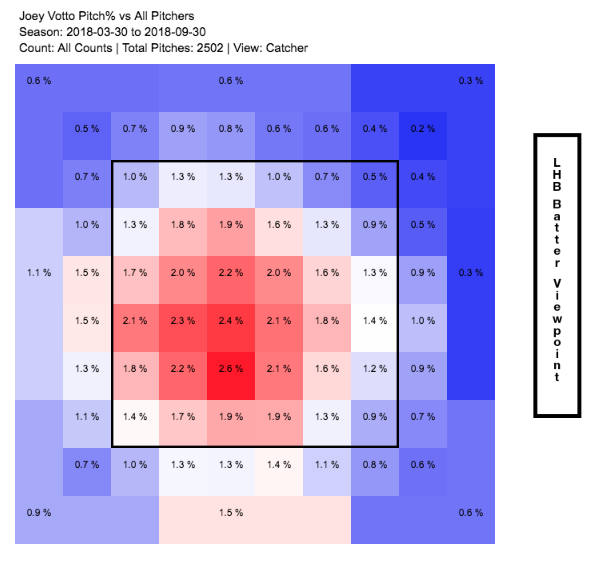

In [13]:
filename="votto_heatmap.png"
Image(filename=filename)

- Implement [SHAP values](https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80) for transparancy/explainability of individual predictions.  In other words, we could supply the user with the information "There's a 77% chance of a fastball BECAUSE (1) the count is 3-2 and (2) there's a runner on second base."
- Test other traditional machine learning techniques such as sequential models like "Hidden Markov Models" (HMMs) or "Compact Prediction Trees" (CPTs).    
- Finally, given more data and more computing resources, it would be interesting to experiment with recurrent neural networks (RNNs), in particular Long-Short-Term-Memory (LSTM) RNNs.  These types of models would capture information about previous pitches (beyond just the last pitch) and use that in the prediction of the next pitch.  The only downside to these models is that they require a lot of data and can take a long time to train.